In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/boostedtiny/pytorch/default/1/best_model_finetuned.pth
/kaggle/input/tinym/pytorch/default/1/best_model.pth
/kaggle/input/aptos2019-blindness-detection/sample_submission.csv
/kaggle/input/aptos2019-blindness-detection/train.csv
/kaggle/input/aptos2019-blindness-detection/test.csv
/kaggle/input/aptos2019-blindness-detection/train_images/ef476be214d4.png
/kaggle/input/aptos2019-blindness-detection/train_images/6dcde47060f9.png
/kaggle/input/aptos2019-blindness-detection/train_images/ec363f48867b.png
/kaggle/input/aptos2019-blindness-detection/train_images/17f6c7072f61.png
/kaggle/input/aptos2019-blindness-detection/train_images/b49b2fac2514.png
/kaggle/input/aptos2019-blindness-detection/train_images/af6166d57f13.png
/kaggle/input/aptos2019-blindness-detection/train_images/8d13c46e7d75.png
/kaggle/input/aptos2019-blindness-detection/train_images/c3b15bf9b4bc.png
/kaggle/input/aptos2019-blindness-detection/train_images/be68322c7223.png
/kaggle/input/aptos2019-blindness-detec

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torchvision.models import convnext_tiny


In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


<Figure size 600x600 with 0 Axes>

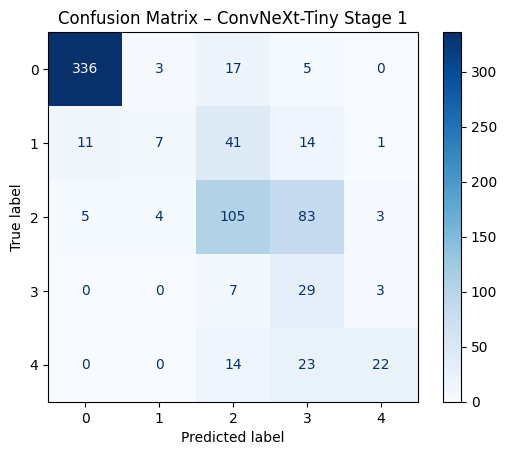

<Figure size 600x600 with 0 Axes>

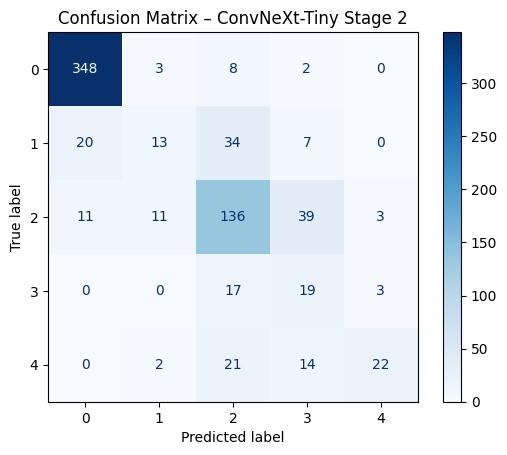

In [4]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image
from torchvision.models import convnext_tiny
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CSV_PATH = "/kaggle/input/aptos2019-blindness-detection/train.csv"
IMG_DIR = "/kaggle/input/aptos2019-blindness-detection/train_images/"

class RetinaDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row["id_code"] + ".png")
        image = read_image(img_path).float() / 255.0
        label = row["diagnosis"]

        if self.transform:
            image = self.transform(image)

        return image, label

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
])

df = pd.read_csv(CSV_PATH)
df["id_code"] = df["id_code"].astype(str)

from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["diagnosis"], random_state=42)

val_dataset = RetinaDataset(val_df, IMG_DIR, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

def get_predictions(model_path, model_name=""):
    model = convnext_tiny(weights=None, num_classes=5)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
    plt.figure(figsize=(6, 6))
    disp.plot(cmap="Blues", values_format='d')
    plt.title(f"Confusion Matrix – {model_name}")
    plt.savefig(f"conf_matrix_{model_name.lower().replace(' ', '_')}.png")
    plt.show()
    return cm

cm_stage1 = get_predictions("/kaggle/input/tinym/pytorch/default/1/best_model.pth", "ConvNeXt-Tiny Stage 1")
cm_stage2 = get_predictions("/kaggle/input/boostedtiny/pytorch/default/1/best_model_finetuned.pth", "ConvNeXt-Tiny Stage 2")
